In [1]:
from google.colab import drive
import os
import random
import pandas as pd
import cv2 as cv
from google.colab.patches import cv2_imshow
from concurrent.futures import ThreadPoolExecutor
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split
import numpy as np

!pip install scikeras
import numpy as np
import pandas as pd
import sklearn as sk
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold
from tensorflow import keras
import tensorflow as tf
import random as python_random
from sklearn.pipeline import Pipeline
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from scikeras.wrappers import KerasClassifier


In [3]:
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
train_folder = '/content/drive/MyDrive/Welding_Dataset/training'
files = os.listdir(train_folder)
print(files)

['NoDefect', 'Crack', 'Porosity', 'LackOfPenetration']


In [5]:
def stratified_sampling(root_dir, num_samples=500, seed=None):
    """
    Perform stratified sampling of files from subfolders of the root directory.

    Args:
        root_dir (str): The root directory containing subfolders.
        num_samples_per_class (int): The number of samples to take from each subfolder.
        seed (int): Random seed for reproducibility.

    Returns:
        A dictionary containing image URLs as keys and their corresponding class names as values.
    """
    if seed is not None:
        random.seed(seed)

    sampled_data = {}

    for class_name in os.listdir(root_dir):
        class_dir = os.path.join(root_dir, class_name)

        if os.path.isdir(class_dir):
            file_list = os.listdir(class_dir)

            if len(file_list) > num_samples:
                random.shuffle(file_list)
                sampled_files = random.sample(file_list, num_samples)
            else:
                sampled_files = file_list

            class_label = class_name

            for file_name in sampled_files:
                file_url = os.path.join(class_dir, file_name)
                sampled_data[file_url] = class_label

    return sampled_data


# Usage
sampled_data = stratified_sampling(train_folder, num_samples=2000, seed=42)

count_per_class = {}

# Count the number of keys per value
for class_label in sampled_data.values():
    count_per_class[class_label] = count_per_class.get(class_label, 0) + 1

# Print the counts
for class_label, count in count_per_class.items():
    print(f'{class_label}: {count} keys')


NoDefect: 2000 keys
Crack: 2000 keys
Porosity: 2000 keys
LackOfPenetration: 2000 keys


In [6]:
def load_image(args):
    url, label = args
    img = cv.imread(url)
    return img, label

def load_images_parallel(data_dict):
    with ThreadPoolExecutor() as executor:
        results = list(executor.map(load_image, data_dict.items()))

    images, labels = zip(*results)
    return np.array(images), np.array(labels)


(227, 227, 3)


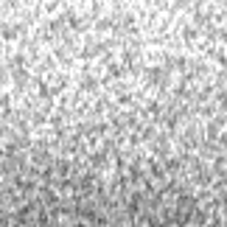

NoDefect


In [7]:

def generate_train_test(data_dict):
    X_list = []
    y_labels = []

    for url, label in data_dict.items():
        X_list.append(url)
        y_labels.append(label)

    X, y = load_images_parallel(data_dict)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    return X_train, X_test, y_train, y_test

x,y,z,t = generate_train_test(sampled_data)

print(np.shape(x[0]))

cv2_imshow(x[0])
print(z[0])

# y_test_encoded = to_categorical(t, num_classes = 4)
# y_train_encoded = to_categorical(z, num_classes = 4)




In [8]:
# We have the image now, need to create the model function here

def create_model(learning_rate=0.001, num_filters=16):
    model = keras.models.Sequential()

    # Define filters and convolutional layers here
    model.add(keras.layers.Conv2D(filters=num_filters, kernel_size=(3, 3),
                            activation='relu', input_shape=(227, 227, 3)))

    # Add a max pooling layer
    model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))

    # Flatten the output and give it to a fully connected layer
    model.add(keras.layers.Flatten())

    # One hidden layer maps the flattened neurons to output
    model.add(keras.layers.Dense(4, activation='softmax'))

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)  # Set the learning rate
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model


In [ ]:
# hyper parameter exploration here